## Exploratory Data Analysis for EyePacs 1K dataset

In [34]:
import pandas as pd
import os
import cv2
import json
import matplotlib.pyplot as plt
from helper_functions import split_eyes, split_eyes_to_lists

## Auto-reload

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
dataset_images_root = "EyePacs1KDataset"
dataset_csv_root = "EyePacs1KDatasetCSV"
dataset_csv = os.path.join(dataset_csv_root, "dataset.csv")
df = pd.read_csv(dataset_csv)
df

case_id  age_at_encounter gender                ethnicity  \
0     1470916                47      F           Latin American   
1     1470912                40      M           Latin American   
2     1470880                21      F           Latin American   
3     1470853                44      N  ethnicity not specified   
4     1470702                45      N  ethnicity not specified   
...       ...               ...    ...                      ...   
1276   255613                31      M                   Latino   
1277   245674                74      M           Latin American   
1278   236937                40      M           Latin American   
1279   215142                38      M           Latin American   
1280    73815                84      M                Caucasian   

     years_with_diabetes  hba1c  cholesterol  triglycerides  \
0         1 year or less    6.2          203          266.0   
1                4 years    6.1          223          326.0   
2                2 years    9.2          165          111.0   
3            16-20 years   11.1          242          166.0   
4         1 year or less    7.0          151          113.0   
...                  ...    ...          ...            ...   
1276          6-10 years    5.6           89          126.0   
1277         11-15 years    5.2          123          146.0   
1278         11-15 years    4.9          191          193.0   
1279         11-15 years    5.6          201           62.0   
1280             2 years    5.6          144          130.0   

                                         pupil_dilation    dr_level_rt  \
0                                         not necessary          No DR   
1                                         not necessary          No DR   
2                                         not necessary          No DR   
3                                         not necessary  Moderate NPDR   
4                                         not necessary          No DR   
...                                                 ...            ...   
1276                              1 gtt. tropicamide 1%    Severe NPDR   
1277                              1 gtt. tropicamide 1%  Moderate NPDR   
1278  declined (please note reason drops were declined)  Moderate NPDR   
1279  declined (please note reason drops were declined)    Severe NPDR   
1280                                                NaN    Severe NPDR   

       dme_rt   dr_level_lft  dme_lft cataract glaucoma occlusion maculopathy  \
0     No CSME          No DR  No CSME      NaN      NaN       NaN         NaN   
1     No CSME          No DR  No CSME      NaN      NaN       NaN         NaN   
2     No CSME          No DR  No CSME      NaN      NaN       NaN         NaN   
3        CSME  Moderate NPDR  No CSME      NaN      NaN       NaN         NaN   
4     No CSME          No DR  No CSME      NaN      NaN       NaN         NaN   
...       ...            ...      ...      ...      ...       ...         ...   
1276  No CSME  Moderate NPDR  No CSME      NaN      NaN       NaN         NaN   
1277  No CSME    Severe NPDR     CSME      NaN     True      True         NaN   
1278     CSME  Moderate NPDR  No CSME      NaN      NaN       NaN         NaN   
1279  No CSME    Severe NPDR  No CSME      NaN      NaN       NaN         NaN   
1280  No CSME  Moderate NPDR  No CSME      NaN      NaN       NaN         NaN   

                 camera  
0     Crystalvue NFC700  
1     Crystalvue NFC700  
2             Canon CR2  
3     Crystalvue NFC700  
4     Crystalvue NFC700  
...                 ...  
1276          Canon CR2  
1277          Canon Dgi  
1278          Canon DGi  
1279       DGi_Canon_na  
1280          Canon DGi  

[1281 rows x 18 columns]

## Validate hba1c split

- 33% of data points below 5.7%
- 33% between 5.7% and 6.5%
- 33% with hba1c over 6.5%

In [37]:
print(f'# of data points below 5.7% {len(df[ (df["hba1c"] < 5.7)]) / len(df)}')
print(f'# of data points between 5.7% and 6.5% { len(df[ (df["hba1c"] < 5.7) & (df["hba1c"] < 6.5) ]) / len(df) }')
print(f'# of data points with hba1c over 6.5% {len(df[ (df["hba1c"] > 6.5)]) / len(df)}')

# of data points below 5.7% 0.3255269320843091
# of data points between 5.7% and 6.5% 0.3255269320843091
# of data points with hba1c over 6.5% 0.3083528493364559


## Validate retinopathy split

Within the subgroup of those having high hba1c:

* pick 25% with no DR
* 25% with moderate+ DR
* 25% with DME
* 25% with VTDR.


In [38]:
df_high_hba1c = df[ (df["hba1c"] > 6.5)]
df_high_hba1c

case_id  age_at_encounter gender                ethnicity  \
2    1470880                21      F           Latin American   
3    1470853                44      N  ethnicity not specified   
4    1470702                45      N  ethnicity not specified   
5    1470690                53      M           Latin American   
6    1470679                56      N  ethnicity not specified   
..       ...               ...    ...                      ...   
798  1355828                78      F  ethnicity not specified   
803  1351160                75      M  ethnicity not specified   
819  1344023                74      M                Caucasian   
825  1340560                76      F           Latin American   
827  1339222                76      F           Latin American   

    years_with_diabetes  hba1c  cholesterol  triglycerides  \
2               2 years    9.2          165          111.0   
3           16-20 years   11.1          242          166.0   
4        1 year or less    7.0          151          113.0   
5            6-10 years   12.1          260          800.0   
6               5 years    6.8          137          147.0   
..                  ...    ...          ...            ...   
798          6-10 years    7.3          102          154.0   
803          6-10 years    6.6           97          142.0   
819          6-10 years    7.1          185           84.0   
825  More than 20 years   14.0          166          201.0   
827  More than 20 years    9.4          223          137.0   

              pupil_dilation       dr_level_rt   dme_rt      dr_level_lft  \
2              not necessary             No DR  No CSME             No DR   
3              not necessary     Moderate NPDR     CSME     Moderate NPDR   
4              not necessary             No DR  No CSME             No DR   
5              not necessary             No DR  No CSME             No DR   
6              not necessary             No DR  No CSME             No DR   
..                       ...               ...      ...               ...   
798            not necessary       Severe NPDR  No CSME       Severe NPDR   
803  1 gtt. tropicamide 0.5%       Severe NPDR  No CSME       Severe NPDR   
819    1 gtt. tropicamide 1%  Proliferative DR  No CSME  Proliferative DR   
825    1 gtt. tropicamide 1%        Ungradable  No CSME  Proliferative DR   
827            not necessary        Ungradable  No CSME       Severe NPDR   

     dme_lft cataract glaucoma occlusion maculopathy             camera  
2    No CSME      NaN      NaN       NaN         NaN          Canon CR2  
3    No CSME      NaN      NaN       NaN         NaN  Crystalvue NFC700  
4    No CSME      NaN      NaN       NaN         NaN  Crystalvue NFC700  
5    No CSME      NaN      NaN       NaN         NaN  Crystalvue NFC700  
6    No CSME      NaN      NaN       NaN         NaN  Crystalvue NFC700  
..       ...      ...      ...       ...         ...                ...  
798  No CSME      NaN      NaN       NaN         NaN    CR-2 AF_Canon_-  
803  No CSME      NaN      NaN       NaN         NaN  Crystalvue NFC700  
819  No CSME      NaN      NaN       NaN         NaN   iCam_Optovue_100  
825  No CSME      NaN      NaN       NaN         NaN    CR-2 AF_Canon_-  
827  No CSME      NaN      NaN       NaN         NaN   iCam_Optovue_100  

[395 rows x 18 columns]

In the high hba1c group, break down the DR stats

In [39]:
df_high_hba1c.groupby("dr_level_rt").describe()

case_id                                                    \
                   count          mean           std        min        25%   
dr_level_rt                                                                  
Mild DR              7.0  1.444115e+06  14853.692041  1423132.0  1435028.5   
Moderate NPDR      154.0  1.453118e+06  17939.677970  1375927.0  1446823.0   
No DR              153.0  1.462308e+06  19288.825790  1358435.0  1465479.0   
Proliferative DR    35.0  1.427847e+06  34067.866394  1344023.0  1406789.5   
Severe NPDR         35.0  1.438692e+06  30559.604802  1351160.0  1437715.5   
Ungradable          11.0  1.432117e+06  47995.444074  1339222.0  1427528.0   

                                                   age_at_encounter  \
                        50%         75%        max            count   
dr_level_rt                                                           
Mild DR           1441411.0  1455303.50  1463596.0              7.0   
Moderate NPDR     1459898.5  1464520.75  1470853.0            154.0   
No DR             1468189.0  1469041.00  1470880.0            153.0   
Proliferative DR  1437297.0  1458043.00  1470095.0             35.0   
Severe NPDR       1449591.0  1458039.00  1467376.0             35.0   
Ungradable        1457724.0  1461175.00  1464667.0             11.0   

                             ... cholesterol        triglycerides              \
                       mean  ...         75%    max         count        mean   
dr_level_rt                  ...                                                
Mild DR           64.714286  ...      180.50  200.0           7.0  141.142857   
Moderate NPDR     55.629870  ...      211.75  392.0         154.0  227.149351   
No DR             56.313725  ...      200.00  559.0         153.0  197.705882   
Proliferative DR  55.485714  ...      209.50  296.0          35.0  178.514286   
Severe NPDR       53.257143  ...      212.00  275.0          35.0  166.657143   
Ungradable        62.090909  ...      211.50  232.0          11.0  130.727273   

                                                                  
                         std   min    25%    50%     75%     max  
dr_level_rt                                                       
Mild DR            38.791874  98.0  107.5  139.0  173.00   190.0  
Moderate NPDR     272.895076  41.0  110.5  157.0  249.25  2575.0  
No DR             212.955360  46.0  102.0  142.0  218.00  2172.0  
Proliferative DR  160.865375  40.0   92.5  135.0  182.00   820.0  
Severe NPDR       112.993218  56.0   85.0  140.0  188.00   491.0  
Ungradable         45.243985  78.0   95.0  137.0  142.00   212.0  

[6 rows x 40 columns]

In the full dataset, break down the DR stats

In [40]:
df.groupby("dr_level_rt").describe()

case_id                                                     \
                   count          mean            std       min         25%   
dr_level_rt                                                                   
Mild DR             40.0  1.216318e+06  217494.562990  651927.0  1012891.00   
Moderate NPDR      450.0  1.280209e+06  220471.792814  236937.0  1195075.00   
No DR              490.0  1.418032e+06  115247.214285  569019.0  1417740.75   
Proliferative DR   140.0  1.197029e+06  270718.289319  259947.0  1096820.50   
Severe NPDR         99.0  1.228007e+06  290145.556669   73815.0  1139860.00   
Ungradable          62.0  1.170466e+06  265625.951121  280431.0   931449.00   

                                                   age_at_encounter  \
                        50%         75%        max            count   
dr_level_rt                                                           
Mild DR           1239141.5  1411255.00  1463625.0             40.0   
Moderate NPDR     1360758.0  1452639.50  1470853.0            450.0   
No DR             1461838.0  1467436.00  1470916.0            490.0   
Proliferative DR  1275413.0  1396432.00  1470095.0            140.0   
Severe NPDR       1295106.0  1440706.00  1467928.0             99.0   
Ungradable        1228924.0  1435234.25  1464667.0             62.0   

                             ... cholesterol        triglycerides              \
                       mean  ...         75%    max         count        mean   
dr_level_rt                  ...                                                
Mild DR           55.275000  ...      185.00  237.0          40.0  123.575000   
Moderate NPDR     55.100000  ...      194.75  392.0         450.0  170.626667   
No DR             55.967347  ...      194.00  647.0         490.0  165.132653   
Proliferative DR  55.185714  ...      181.25  328.0         140.0  137.071429   
Severe NPDR       53.686869  ...      203.00  348.0          99.0  154.878788   
Ungradable        61.629032  ...      204.00  294.0          62.0  138.080645   

                                                                  
                         std   min    25%    50%     75%     max  
dr_level_rt                                                       
Mild DR            54.841444  30.0  81.50  117.0  161.25   269.0  
Moderate NPDR     176.012573   7.0  93.25  135.0  194.00  2575.0  
No DR             200.874908  32.0  91.00  125.0  186.75  3334.0  
Proliferative DR   98.833968  30.0  86.75  115.0  167.75   820.0  
Severe NPDR        97.105904  30.0  82.50  127.0  182.50   491.0  
Ungradable         66.692910  49.0  87.00  129.5  185.25   312.0  

[6 rows x 40 columns]

## Demographics

- The broader the ages we cover the better. Thus, 20% between 25-40, 20%
41-50, 20% 51-60, 20% 61-70, 20% over 70
- sex: 50% male 50% female

In [41]:
print(f'# of data points between age 25-40 {len(df[ (df["age_at_encounter"] <= 40)]) / len(df)}')
print(f'# of data points between age 41-50 {len(df[ (df["age_at_encounter"] > 40) & (df["age_at_encounter"] <= 50) ]) / len(df)}')
print(f'# of data points between age 51-60 {len(df[ (df["age_at_encounter"] > 50) & (df["age_at_encounter"] <= 60) ]) / len(df)}')
print(f'# of data points between age 61-70 {len(df[ (df["age_at_encounter"] > 60) & (df["age_at_encounter"] <= 70) ]) / len(df)}')
print(f'# of data points age 70+ {len(df[ (df["age_at_encounter"] > 70)]) / len(df)}')

# of data points between age 25-40 0.1881342701014832
# of data points between age 41-50 0.21701795472287275
# of data points between age 51-60 0.20530835284933646
# of data points between age 61-70 0.19828259172521467
# of data points age 70+ 0.1912568306010929


In [42]:
df.groupby("gender").describe()

case_id                                                                \
         count          mean            std        min        25%        50%   
gender                                                                         
F        563.0  1.323649e+06  209486.726667   259947.0  1252309.0  1422994.0   
M        644.0  1.292445e+06  235659.041312    73815.0  1212537.0  1392272.0   
N         65.0  1.423361e+06  114131.965044   898744.0  1436673.0  1458689.0   
O          1.0  1.037980e+06            NaN  1037980.0  1037980.0  1037980.0   

                              age_at_encounter             ... cholesterol  \
               75%        max            count       mean  ...         75%   
gender                                                     ...               
F       1463000.00  1470916.0            563.0  57.646536  ...       203.0   
M       1458536.75  1470912.0            644.0  54.170807  ...       185.0   
N       1467975.00  1470853.0             65.0  51.876923  ...       213.0   
O       1037980.00  1037980.0              1.0  63.000000  ...       112.0   

              triglycerides                                               \
          max         count        mean         std    min    25%    50%   
gender                                                                     
F       559.0         563.0  165.275311  169.289947    7.0   98.0  133.0   
M       647.0         644.0  156.127329  174.412944   22.0   83.0  120.0   
N       271.0          65.0  163.953846  108.404974   41.0   98.0  134.0   
O       112.0           1.0  180.000000         NaN  180.0  180.0  180.0   

                       
          75%     max  
gender                 
F       184.0  2575.0  
M       186.0  3334.0  
N       206.0   749.0  
O       180.0   180.0  

[4 rows x 40 columns]

## Overall data quality

Filter out encounters with NULL values.

In [43]:
len(df[df["hba1c"].isnull()])

0

## Exploring data

### Relationship between hba1c and diabetes

For people with diabetes, plot their hba1c levels

In [44]:
df[["years_with_diabetes", "hba1c"]].groupby("years_with_diabetes").describe()

hba1c                                                   
                     count      mean       std   min   25%   50%    75%   max
years_with_diabetes                                                          
1 year or less       167.0  6.445509  1.901702  0.00  5.60  6.10  6.500  14.0
11-15 years          161.0  6.862733  2.367747  0.00  5.60  6.20  7.600  14.0
16-20 years          127.0  7.164331  2.412378  0.14  5.60  6.40  8.400  14.0
2 years              118.0  6.479661  1.724314  4.40  5.60  6.00  6.475  13.1
3 years               70.0  6.417143  1.552275  4.30  5.60  6.15  6.500  13.3
4 years               59.0  6.506780  1.299982  5.10  5.55  6.20  6.600  10.9
5 years               68.0  7.262059  2.590878  4.80  5.60  6.10  7.900  14.0
6-10 years           259.0  7.146718  2.190399  0.00  5.60  6.30  8.050  14.0
Border line           52.0  5.676923  0.518904  4.40  5.40  5.60  6.100   6.9
Gestational            2.0  5.700000  0.141421  5.60  5.65  5.70  5.750   5.8
More than 20 years   168.0  7.207738  2.182319  0.00  5.80  6.40  8.325  14.0
Not diabetic          26.0  5.430769  0.244572  4.80  5.30  5.50  5.600   5.8
Unknown                4.0  7.650000  1.694107  6.10  6.25  7.55  8.950   9.4

### Relationship between hba1c and DBR

For people with DBR, plot their hba1c levels

In [45]:
df[["dr_level_rt", "hba1c"]].groupby("dr_level_rt").describe()

hba1c                                                
                  count      mean       std  min  25%  50%    75%   max
dr_level_rt                                                            
Mild DR            40.0  6.177500  1.293274  4.3  5.5  5.8  6.300   9.9
Moderate NPDR     450.0  7.032867  2.480820  0.0  5.6  6.3  8.100  14.0
No DR             490.0  6.632245  1.658670  4.2  5.6  6.1  7.000  13.7
Proliferative DR  140.0  6.776429  2.077997  4.5  5.5  6.2  6.525  14.0
Severe NPDR        99.0  7.140404  2.303764  4.6  5.6  6.3  7.850  14.0
Ungradable         62.0  6.543548  2.004554  5.0  5.5  5.9  6.500  14.0

### How many pupils are dialated?

From the nature paper, "On dilated pupils, the AUCs were consistently 5–10% higher".  Therefore, this can affect results.


In [46]:
df.groupby("pupil_dilation").describe()

case_id                \
                                                     count          mean   
pupil_dilation                                                             
1 gtt. tropicamide 0.5%                               43.0  1.432869e+06   
1 gtt. tropicamide 1%                                188.0  1.204347e+06   
declined (please note reason drops were declined)     26.0  1.301458e+06   
not necessary                                       1016.0  1.333598e+06   
other dilating agents (please note dilating age...     3.0  1.082331e+06   

                                                                              \
                                                              std        min   
pupil_dilation                                                                 
1 gtt. tropicamide 0.5%                              49054.225342  1249294.0   
1 gtt. tropicamide 1%                               288310.924048   245674.0   
declined (please note reason drops were declined)   321871.673567   215142.0   
not necessary                                       187233.946470   319896.0   
other dilating agents (please note dilating age...  223976.379077   898093.0   

                                                                           \
                                                           25%        50%   
pupil_dilation                                                              
1 gtt. tropicamide 0.5%                             1420443.50  1452240.0   
1 gtt. tropicamide 1%                               1025815.25  1281360.5   
declined (please note reason drops were declined)   1343177.00  1404768.0   
not necessary                                       1257332.25  1422923.5   
other dilating agents (please note dilating age...   957678.50  1017264.0   

                                                                           \
                                                           75%        max   
pupil_dilation                                                              
1 gtt. tropicamide 0.5%                             1462743.50  1468601.0   
1 gtt. tropicamide 1%                               1454169.75  1470389.0   
declined (please note reason drops were declined)   1417968.00  1466361.0   
not necessary                                       1462689.00  1470916.0   
other dilating agents (please note dilating age...  1174450.50  1331637.0   

                                                   age_at_encounter  \
                                                              count   
pupil_dilation                                                        
1 gtt. tropicamide 0.5%                                        43.0   
1 gtt. tropicamide 1%                                         188.0   
declined (please note reason drops were declined)              26.0   
not necessary                                                1016.0   
other dilating agents (please note dilating age...              3.0   

                                                               ...  \
                                                         mean  ...   
pupil_dilation                                                 ...   
1 gtt. tropicamide 0.5%                             61.581395  ...   
1 gtt. tropicamide 1%                               58.707447  ...   
declined (please note reason drops were declined)   56.038462  ...   
not necessary                                       54.811024  ...   
other dilating agents (please note dilating age...  58.000000  ...   

                                                   cholesterol         \
                                                           75%    max   
pupil_dilation                                                          
1 gtt. tropicamide 0.5%                                  199.0  300.0   
1 gtt. tropicamide 1%                                    181.0  359.0   
declined (please note reason drops were declined)        190.0  237.0   

### DME

In [47]:
df.groupby("dme_rt").describe()

case_id                                                               \
          count          mean            std       min        25%        50%   
dme_rt                                                                         
CSME      127.0  1.211290e+06  248290.136639  236937.0  1057477.5  1273116.0   
No CSME  1154.0  1.323634e+06  216040.879120   73815.0  1252496.0  1423631.0   

                              age_at_encounter             ... cholesterol  \
               75%        max            count       mean  ...         75%   
dme_rt                                                     ...               
CSME     1425203.0  1470853.0            127.0  55.511811  ...       204.5   
No CSME  1462786.5  1470916.0           1154.0  55.668977  ...       193.0   

               triglycerides                                             \
           max         count        mean         std   min   25%    50%   
dme_rt                                                                    
CSME     300.0         127.0  152.889764   87.103681  39.0  91.0  140.0   
No CSME  647.0        1154.0  161.444541  175.642034   7.0  88.0  125.0   

                        
           75%     max  
dme_rt                  
CSME     191.0   697.0  
No CSME  185.0  3334.0  

[2 rows x 40 columns]

In [48]:
len(df[df["maculopathy"] == True])

25

## Images

### Create resized images of 587x587

This will speed up training due to faster loading


In [49]:
def create_resized_images(new_size_width_height: tuple, dataset_images_root: str, resized_images_root: str):
    """
    @param new_size_width_height: tuple of (width, height)
    @param dataset_images_root: root directory of the dataset images
    @param output_dir: directory to save the resized images, relative to dataset_images_root
    """
    if not os.path.exists(resized_images_root):
        os.mkdir(resized_images_root)

    for filename in os.listdir(dataset_images_root):
        if not filename.lower().endswith(".jpg"):
            continue
        if not "external" in filename.lower():
            continue

        target_file_fp = os.path.join(resized_images_root, filename)
        if os.path.exists(target_file_fp):
            continue

        image = cv2.imread(os.path.join(dataset_images_root, filename))
        image = cv2.resize(image, new_size_width_height)
        cv2.imwrite(os.path.join(resized_images_root, filename), image)

resized_images_root = os.path.join(dataset_images_root, "587_587_resized_images")

create_resized_images(
    (587, 587), 
    dataset_images_root, 
    resized_images_root
)


### Build index of images

Create a dictionary where each entry points to a list that contains the external eye images

Case id -> [eye1_filename, eye2_filename]

In most cases should be left and right eye, however sometime these are mis-labeled.  For example:

* 1021028_1470702_14560287_Left External.jpg
* 1021028_1470702_14560288_Left External.jpg




In [50]:
def build_image_index(resized_images_root):
    
    result = {}

    for filename in os.listdir(resized_images_root):
        if not filename.lower().endswith(".jpg"):
            continue
        if not "external" in filename.lower():
            continue

        # Parse out the case id, which is the second field.  Eg
        # 683661_1297764_13327952_Left External.JPG -> 1297764
        case_id = int(filename.split("_")[1])

        if case_id not in result:
            result[case_id] = []

        result[case_id].append(os.path.join(resized_images_root, filename))

    return result

image_index = build_image_index(resized_images_root)


### Create dataframe with image filename cols


In [51]:
def get_eye_image_filenames(row):  
    if row["case_id"] not in image_index:
        return None
    image_filenames = image_index[row["case_id"]]
    if len(image_filenames) == 0:
        return None
    return image_filenames
    #return str(image_filenames)

def get_num_eye_image_filenames(row):  
    eye_image_filenames = get_eye_image_filenames(row)
    if eye_image_filenames is None:
        return 0
    return len(eye_image_filenames)

def left_right_dr_mismatch(row):
    """
    Add boolean column to describe whether the left and right DR levels are different
    """
    return row["dr_level_lft"] != row["dr_level_rt"]

df['eye_image_filenames'] = df.apply(lambda row: get_eye_image_filenames(row), axis=1)
df['num_eye_image_filenames'] = df.apply(lambda row: get_num_eye_image_filenames(row), axis=1)
df['left_right_dr_mismatch'] = df.apply(lambda row: left_right_dr_mismatch(row), axis=1)

df

case_id  age_at_encounter gender                ethnicity  \
0     1470916                47      F           Latin American   
1     1470912                40      M           Latin American   
2     1470880                21      F           Latin American   
3     1470853                44      N  ethnicity not specified   
4     1470702                45      N  ethnicity not specified   
...       ...               ...    ...                      ...   
1276   255613                31      M                   Latino   
1277   245674                74      M           Latin American   
1278   236937                40      M           Latin American   
1279   215142                38      M           Latin American   
1280    73815                84      M                Caucasian   

     years_with_diabetes  hba1c  cholesterol  triglycerides  \
0         1 year or less    6.2          203          266.0   
1                4 years    6.1          223          326.0   
2                2 years    9.2          165          111.0   
3            16-20 years   11.1          242          166.0   
4         1 year or less    7.0          151          113.0   
...                  ...    ...          ...            ...   
1276          6-10 years    5.6           89          126.0   
1277         11-15 years    5.2          123          146.0   
1278         11-15 years    4.9          191          193.0   
1279         11-15 years    5.6          201           62.0   
1280             2 years    5.6          144          130.0   

                                         pupil_dilation    dr_level_rt  ...  \
0                                         not necessary          No DR  ...   
1                                         not necessary          No DR  ...   
2                                         not necessary          No DR  ...   
3                                         not necessary  Moderate NPDR  ...   
4                                         not necessary          No DR  ...   
...                                                 ...            ...  ...   
1276                              1 gtt. tropicamide 1%    Severe NPDR  ...   
1277                              1 gtt. tropicamide 1%  Moderate NPDR  ...   
1278  declined (please note reason drops were declined)  Moderate NPDR  ...   
1279  declined (please note reason drops were declined)    Severe NPDR  ...   
1280                                                NaN    Severe NPDR  ...   

       dr_level_lft  dme_lft cataract glaucoma occlusion maculopathy  \
0             No DR  No CSME      NaN      NaN       NaN         NaN   
1             No DR  No CSME      NaN      NaN       NaN         NaN   
2             No DR  No CSME      NaN      NaN       NaN         NaN   
3     Moderate NPDR  No CSME      NaN      NaN       NaN         NaN   
4             No DR  No CSME      NaN      NaN       NaN         NaN   
...             ...      ...      ...      ...       ...         ...   
1276  Moderate NPDR  No CSME      NaN      NaN       NaN         NaN   
1277    Severe NPDR     CSME      NaN     True      True         NaN   
1278  Moderate NPDR  No CSME      NaN      NaN       NaN         NaN   
1279    Severe NPDR  No CSME      NaN      NaN       NaN         NaN   
1280  Moderate NPDR  No CSME      NaN      NaN       NaN         NaN   

                 camera                                eye_image_filenames  \
0     Crystalvue NFC700  [EyePacs1KDataset/587_587_resized_images/10211...   
1     Crystalvue NFC700  [EyePacs1KDataset/587_587_resized_images/10211...   
2             Canon CR2  [EyePacs1KDataset/587_587_resized_images/86683...   
3     Crystalvue NFC700  [EyePacs1KDataset/587_587_resized_images/10211...   
4     Crystalvue NFC700  [EyePacs1KDataset/587_587_resized_images/10210...   
...                 ...                                                ...   
1276          Canon CR2  [EyePacs1KDataset/587_587_resized_images/4685_...   
1277  

In [52]:
df.groupby("num_eye_image_filenames").describe()

case_id                                          \
                          count          mean            std        min   
num_eye_image_filenames                                                   
0                         133.0  1.368434e+06  164241.199363   772402.0   
1                          11.0  1.389827e+06  102340.047059  1120113.0   
2                        1087.0  1.317505e+06  199006.464255   523593.0   
3                          11.0  1.252457e+06  296299.928768   526584.0   
4                          22.0  1.326210e+06  154708.529858   958019.0   
5                           3.0  1.380921e+06   42239.394034  1334919.0   
7                           1.0  1.385818e+06            NaN  1385818.0   
8                          12.0  2.634880e+05   68580.449916    73815.0   
9                           1.0  2.456740e+05            NaN   245674.0   

                                                                       \
                                25%        50%         75%        max   
num_eye_image_filenames                                                 
0                        1304770.00  1459821.0  1466562.00  1469641.0   
1                        1383976.50  1431768.0  1451978.00  1464898.0   
2                        1231555.00  1410668.0  1461464.00  1470916.0   
3                        1190807.00  1382979.0  1449568.50  1469041.0   
4                        1301948.75  1385912.0  1417312.50  1467374.0   
5                        1362401.50  1389884.0  1403921.50  1417959.0   
7                        1385818.00  1385818.0  1385818.00  1385818.0   
8                         250944.00   285475.5   299874.25   329740.0   
9                         245674.00   245674.0   245674.00   245674.0   

                        age_at_encounter             ... cholesterol         \
                                   count       mean  ...         75%    max   
num_eye_image_filenames                              ...                      
0                                  133.0  56.195489  ...       185.0  559.0   
1                                   11.0  61.545455  ...       205.0  239.0   
2                                 1087.0  55.497700  ...       195.0  647.0   
3                                   11.0  52.363636  ...       199.0  233.0   
4                                   22.0  58.090909  ...       202.5  265.0   
5                                    3.0  65.333333  ...       167.5  178.0   
7                                    1.0  40.000000  ...       274.0  274.0   
8                                   12.0  54.250000  ...       170.0  216.0   
9                                    1.0  74.000000  ...       123.0  123.0   

                        triglycerides                                         \
                                count        mean         std    min     25%   
num_eye_image_filenames                                                        
0                               133.0  144.774436  191.292795   37.0   82.00   
1                                11.0  171.545455  108.010521   50.0  101.50   
2                              1087.0  161.879485  167.492836    7.0   88.00   
3                                11.0  219.000000  273.011721   50.0  106.50   
4                                22.0  171.363636   96.333521   68.0  103.25   
5                                 3.0  186.666667   58.620247  126.0  158.50   
7                                 1.0  388.000000         NaN  388.0  388.00   
8                                12.0  112.166667   37.452596   61.0   87.75   
9                                 1.0  146.000000         NaN  146.0  146.00   

                                                
                           50%     75%     max  
num_eye_image_filenames                         
0                        115.0  149.00  2172.0  
1                        134.0  199.00   422.0  
2                        128.0  189.50  3334.0  
3                        124.0  186.00  10

In [53]:
df["case_id"].isnull().sum()

0

### Create dataframe with subset of rows that have either a left or a right eye external image

In [54]:
def has_either_eye_image(row):
    if row['left_eye_image_fn'] is not None:
        return True
    elif row['right_eye_image_fn'] is not None:
        return True
    else:
        return False


# In order to work around data quality issues, we will only use data points that have either 1 or 2 eye images since
# images with more than 2 eye images are likely to include fundus images, which we don't want to use.  
# Reported to EyePacs on 2020-02-08
df_one_or_two_eye_images = df[ (df['num_eye_image_filenames'] > 0) & (df['num_eye_image_filenames'] < 3) ]

# Missing eye images.  Reported to EyePacs on 2020-02-08
df_missing_eye_images = df[df['num_eye_image_filenames'] == 0]

# Useful for inspecting images that are likely to be fundus images
df_three_plus_eye_images = df[df['num_eye_image_filenames'] >= 3]

In [55]:
df_one_or_two_eye_images

case_id  age_at_encounter gender                ethnicity  \
0     1470916                47      F           Latin American   
1     1470912                40      M           Latin American   
2     1470880                21      F           Latin American   
3     1470853                44      N  ethnicity not specified   
4     1470702                45      N  ethnicity not specified   
...       ...               ...    ...                      ...   
1262   569019                38      M  ethnicity not specified   
1263   560798                33      M  ethnicity not specified   
1264   559463                66      F           Latin American   
1265   546702                40      M           Latin American   
1267   523593                29      M           Latin American   

     years_with_diabetes  hba1c  cholesterol  triglycerides  \
0         1 year or less    6.2          203          266.0   
1                4 years    6.1          223          326.0   
2                2 years    9.2          165          111.0   
3            16-20 years   11.1          242          166.0   
4         1 year or less    7.0          151          113.0   
...                  ...    ...          ...            ...   
1262          6-10 years    5.6          178           32.0   
1263      1 year or less    5.5          155          150.0   
1264             2 years    5.2          164          101.0   
1265          6-10 years    5.4          133           79.0   
1267             2 years    5.6          138          264.0   

             pupil_dilation       dr_level_rt  ...      dr_level_lft  dme_lft  \
0             not necessary             No DR  ...             No DR  No CSME   
1             not necessary             No DR  ...             No DR  No CSME   
2             not necessary             No DR  ...             No DR  No CSME   
3             not necessary     Moderate NPDR  ...     Moderate NPDR  No CSME   
4             not necessary             No DR  ...             No DR  No CSME   
...                     ...               ...  ...               ...      ...   
1262  1 gtt. tropicamide 1%             No DR  ...        Ungradable     CSME   
1263          not necessary     Moderate NPDR  ...           Mild DR  No CSME   
1264  1 gtt. tropicamide 1%  Proliferative DR  ...  Proliferative DR  No CSME   
1265  1 gtt. tropicamide 1%     Moderate NPDR  ...             No DR  No CSME   
1267          not necessary     Moderate NPDR  ...             No DR  No CSME   

     cataract glaucoma occlusion maculopathy             camera  \
0         NaN      NaN       NaN         NaN  Crystalvue NFC700   
1         NaN      NaN       NaN         NaN  Crystalvue NFC700   
2         NaN      NaN       NaN         NaN          Canon CR2   
3         NaN      NaN       NaN         NaN  Crystalvue NFC700   
4         NaN      NaN       NaN         NaN  Crystalvue NFC700   
...       ...      ...       ...         ...                ...   
1262      NaN      NaN       NaN         NaN          Canon CR2   
1263      NaN      NaN       NaN         NaN          Canon DGi   
1264      NaN      NaN       NaN         NaN       CR1_Canon_na   
1265      NaN      NaN       NaN         NaN          Canon CR2   
1267      NaN      NaN       NaN         NaN          Canon Dgi   

                                    eye_image_filenames  \
0     [EyePacs1KDataset/587_587_resized_images/10211...   
1     [EyePacs1KDataset/587_587_resized_images/10211...   
2     [EyePacs1KDataset/587_587_resized_images/86683...   
3     [EyePacs1KDataset/587_587_resized_images/10211...   
4     [EyePacs1KDataset/587_587_resized_images/10210...   
...                                                 ...   
1262  [EyePacs1KDataset/587_587_resized_images/52628...   
1263  [EyePacs1KDataset/587_587_resized_images/40043...   
1264  [EyePacs1KDataset/587_587_resized_images/39942...   
1265  [EyePacs1KDataset/587_587_resized_images/38735...   
1267  [EyePacs1KD

In [56]:
df_missing_eye_images

case_id  age_at_encounter gender        ethnicity years_with_diabetes  \
27    1469641                47      M   Latin American             5 years   
28    1469637                53      M  African Descent      1 year or less   
29    1469637                53      M  African Descent      1 year or less   
30    1469637                53      M  African Descent      1 year or less   
32    1469623                68      M  African Descent         11-15 years   
...       ...               ...    ...              ...                 ...   
1179   931449                55      F  African Descent          6-10 years   
1180   931449                55      F  African Descent          6-10 years   
1181   931449                55      F  African Descent          6-10 years   
1227   844512                63      M   Latin American  More than 20 years   
1241   772402                44      M   Latin American  More than 20 years   

      hba1c  cholesterol  triglycerides         pupil_dilation  \
27      9.5          263          335.0  1 gtt. tropicamide 1%   
28      5.8          107          180.0          not necessary   
29      5.8          107          180.0          not necessary   
30      5.8          107          180.0          not necessary   
32      7.6          126           96.0          not necessary   
...     ...          ...            ...                    ...   
1179    5.5          137           87.0          not necessary   
1180    5.5          137           87.0          not necessary   
1181    5.5          137           87.0          not necessary   
1227    5.5          117           87.0  1 gtt. tropicamide 1%   
1241    5.5          117           99.0  1 gtt. tropicamide 1%   

           dr_level_rt  ...      dr_level_lft  dme_lft cataract glaucoma  \
27       Moderate NPDR  ...     Moderate NPDR  No CSME      NaN      NaN   
28               No DR  ...             No DR  No CSME      NaN      NaN   
29               No DR  ...             No DR  No CSME      NaN      NaN   
30               No DR  ...             No DR  No CSME      NaN      NaN   
32               No DR  ...             No DR  No CSME      NaN      NaN   
...                ...  ...               ...      ...      ...      ...   
1179        Ungradable  ...     Moderate NPDR     CSME      NaN      NaN   
1180        Ungradable  ...     Moderate NPDR     CSME      NaN      NaN   
1181        Ungradable  ...     Moderate NPDR     CSME      NaN      NaN   
1227  Proliferative DR  ...     Moderate NPDR  No CSME      NaN      NaN   
1241        Ungradable  ...  Proliferative DR  No CSME      NaN      NaN   

     occlusion maculopathy            camera eye_image_filenames  \
27         NaN         NaN   DRS_Centervue_-                None   
28         NaN         NaN     Centervue DRS                None   
29         NaN         NaN  iCam_Optovue_100                None   
30         NaN         NaN               NaN                None   
32         NaN         NaN     Centervue DRS                None   
...        ...         ...               ...                 ...   
1179       NaN         NaN     Centervue DRS                None   
1180       NaN         NaN  iCam_Optovue_100                None   
1181       NaN         NaN               NaN                None   
1227       NaN         NaN   DRS_Centervue_-                None   
1241       NaN         NaN   DRS_Centervue_-                None   

     num_eye_image_filenames  left_right_dr_mismatch  
27                         0                   False  
28                         0                   False  
29                         0                   False  
30                         0                   False  
32                         0                   False  
...                      ...                     ...  
1179                       0                    True  
1180                       0                    True  
1181                       0           

In [57]:
df_three_plus_eye_images

case_id  age_at_encounter gender                ethnicity  \
68    1469041                65      N  ethnicity not specified   
151   1467374                38      F           Latin American   
170   1467082                35      F  ethnicity not specified   
242   1464420                65      M           Latin American   
281   1463135                36      N  ethnicity not specified   
286   1463008                74      F                Caucasian   
405   1457738                46      N  ethnicity not specified   
527   1441399                64      F           Latin American   
589   1428360                39      F           Latin American   
605   1425111                64      F  ethnicity not specified   
623   1417971                87      F           Latin American   
624   1417959                81      F           Latin American   
633   1415337                34      F           Latin American   
648   1412388                46      M           Latin American   
650   1412337                74      F           Latin American   
659   1409652                39      M           Latin American   
698   1399884                63      N  ethnicity not specified   
731   1389884                63      M          African Descent   
740   1385818                40      M           Latin American   
741   1382979                46      F           Latin American   
766   1371940                76      M           Latin American   
776   1366832                34      M                    Asian   
782   1364542                36      F           Latin American   
819   1344023                74      M                Caucasian   
823   1343279                53      M          African Descent   
829   1334919                52      M           Latin American   
869   1303146                38      M           Latin American   
883   1288172                72      M           Latin American   
893   1275172                64      M                Caucasian   
1032  1190014                80      F           Latin American   
1069  1128874                60      M          African Descent   
1086  1106442                82      F           Latin American   
1119  1048610                58      F           Latin American   
1136  1018442                73      F           Latin American   
1173   958019                67      F           Latin American   
1190   922333                39      F                Caucasian   
1266   526584                33      M           Latin American   
1268   329740                67      F                Caucasian   
1269   319896                69      M           Latin American   
1270   306592                74      F           Latin American   
1271   297635                41      F  ethnicity not specified   
1272   295588                64      M           Latin American   
1273   290520                38      M                Caucasian   
1274   280431                73      M           Latin American   
1275   259947                32      F                    Other   
1276   255613                31      M                   Latino   
1277   245674                74      M           Latin American   
1278   236937                40      M           Latin American   
1279   215142                38      M           Latin American   
1280    73815                84      M                Caucasian   

     years_with_diabetes  hba1c  cholesterol  triglycerides  \
68            6-10 years    8.3          233          170.0   
151           6-10 years    6.2          217          241.0   
170              4 years    8.1          231         1015.0   
242           6-10 years    7.3          162          159.0   
281              2 years    6.5          194          254.0   
286           6-10 years    6.0          179           85.0   
405           6-10 years    7.2          124          106.0   
527           6-10 years    6.4          189          202.0   
589              5 ye

In [58]:
df_one_or_two_eye_images.groupby("pupil_dilation").describe()

case_id                \
                                                     count          mean   
pupil_dilation                                                             
1 gtt. tropicamide 0.5%                               42.0  1.432054e+06   
1 gtt. tropicamide 1%                                163.0  1.225049e+06   
declined (please note reason drops were declined)      9.0  1.415288e+06   
not necessary                                        881.0  1.329855e+06   
other dilating agents (please note dilating age...     3.0  1.082331e+06   

                                                                              \
                                                              std        min   
pupil_dilation                                                                 
1 gtt. tropicamide 0.5%                              49353.600074  1249294.0   
1 gtt. tropicamide 1%                               249859.518267   546702.0   
declined (please note reason drops were declined)    79004.289054  1233373.0   
not necessary                                       186099.968164   523593.0   
other dilating agents (please note dilating age...  223976.379077   898093.0   

                                                                           \
                                                           25%        50%   
pupil_dilation                                                              
1 gtt. tropicamide 0.5%                             1418493.75  1452000.5   
1 gtt. tropicamide 1%                               1035204.00  1286943.0   
declined (please note reason drops were declined)   1410264.00  1455008.0   
not necessary                                       1251175.00  1412428.0   
other dilating agents (please note dilating age...   957678.50  1017264.0   

                                                                           \
                                                           75%        max   
pupil_dilation                                                              
1 gtt. tropicamide 0.5%                             1462411.25  1468601.0   
1 gtt. tropicamide 1%                               1455529.50  1470389.0   
declined (please note reason drops were declined)   1461524.00  1466361.0   
not necessary                                       1461875.00  1470916.0   
other dilating agents (please note dilating age...  1174450.50  1331637.0   

                                                   age_at_encounter  \
                                                              count   
pupil_dilation                                                        
1 gtt. tropicamide 0.5%                                        42.0   
1 gtt. tropicamide 1%                                         163.0   
declined (please note reason drops were declined)               9.0   
not necessary                                                 881.0   
other dilating agents (please note dilating age...              3.0   

                                                               ...  \
                                                         mean  ...   
pupil_dilation                                                 ...   
1 gtt. tropicamide 0.5%                             62.214286  ...   
1 gtt. tropicamide 1%                               59.570552  ...   
declined (please note reason drops were declined)   59.000000  ...   
not necessary                                       54.455165  ...   
other dilating agents (please note dilating age...  58.000000  ...   

                                                   triglycerides          \
                                                             75%     max   
pupil_dilation                                                             
1 gtt. tropicamide 0.5%                                    208.0  1283.0   
1 gtt. tropicamide 1%                                      174.0   447.0   
declined (please note reason drops were declined)        

### Find image sizes of external eye images

In [59]:
# Disable since this is slow and was only needed once

# image_sizes = []

# for index, row in df_one_or_two_eye_images.iterrows():
#     for image_filename in row["eye_image_filenames"]:
#         image_filename_fp = os.path.join(dataset_images_root, image_filename)
#         img = cv2.imread(image_filename_fp)
#         height, width, channels = img.shape     
#         image_sizes.append([image_filename, height, width, channels])

        

# image_sizes_df = pd.DataFrame(image_sizes, columns=['image_filename', 'height', 'width', 'channels'])

# image_sizes_df.groupby("width").describe()

## Data prep

### Find discrepancies of left eye vs right eye

It doesn't make sense that the left eye has a different DR value than the right eye.  These should be made consistent.

In [60]:
df_left_right_dr_discrepancies = df_one_or_two_eye_images[df_one_or_two_eye_images["left_right_dr_mismatch"] == True]

In [61]:
df_left_right_dr_discrepancies

case_id  age_at_encounter gender                ethnicity  \
18    1470025                72      F           Latin American   
19    1470022                65      F           Latin American   
20    1469988                69      N  ethnicity not specified   
50    1469486                68      M          African Descent   
63    1469172                67      M           Latin American   
...       ...               ...    ...                      ...   
1259   582466                35      M                      NaN   
1262   569019                38      M  ethnicity not specified   
1263   560798                33      M  ethnicity not specified   
1265   546702                40      M           Latin American   
1267   523593                29      M           Latin American   

     years_with_diabetes  hba1c  cholesterol  triglycerides  \
18           11-15 years    7.9          193          238.0   
19    More than 20 years    8.1          141          303.0   
20           11-15 years    8.0          104           90.0   
50            6-10 years    6.7          135           66.0   
63            6-10 years    9.7          140          181.0   
...                  ...    ...          ...            ...   
1259             5 years    5.5          167          268.0   
1262          6-10 years    5.6          178           32.0   
1263      1 year or less    5.5          155          150.0   
1265          6-10 years    5.4          133           79.0   
1267             2 years    5.6          138          264.0   

             pupil_dilation    dr_level_rt  ... dr_level_lft  dme_lft  \
18    1 gtt. tropicamide 1%  Moderate NPDR  ...        No DR  No CSME   
19    1 gtt. tropicamide 1%  Moderate NPDR  ...      Mild DR  No CSME   
20            not necessary  Moderate NPDR  ...      Mild DR  No CSME   
50            not necessary          No DR  ...   Ungradable  No CSME   
63            not necessary  Moderate NPDR  ...        No DR  No CSME   
...                     ...            ...  ...          ...      ...   
1259          not necessary  Moderate NPDR  ...   Ungradable  No CSME   
1262  1 gtt. tropicamide 1%          No DR  ...   Ungradable     CSME   
1263          not necessary  Moderate NPDR  ...      Mild DR  No CSME   
1265  1 gtt. tropicamide 1%  Moderate NPDR  ...        No DR  No CSME   
1267          not necessary  Moderate NPDR  ...        No DR  No CSME   

     cataract glaucoma occlusion maculopathy             camera  \
18        NaN      NaN       NaN         NaN    CR-2 AF_Canon_-   
19        NaN      NaN       NaN         NaN          Canon CR2   
20        NaN      NaN       NaN         NaN  Crystalvue NFC700   
50        NaN     True       NaN         NaN      NW_Topcon_400   
63        NaN      NaN       NaN         NaN   iCam_Optovue_100   
...       ...      ...       ...         ...                ...   
1259      NaN      NaN       NaN         NaN          Canon DGi   
1262      NaN      NaN       NaN         NaN          Canon CR2   
1263      NaN      NaN       NaN         NaN          Canon DGi   
1265      NaN      NaN       NaN         NaN          Canon CR2   
1267      NaN      NaN       NaN         NaN          Canon Dgi   

                                    eye_image_filenames  \
18    [EyePacs1KDataset/587_587_resized_images/39574...   
19    [EyePacs1KDataset/587_587_resized_images/97394...   
20    [EyePacs1KDataset/587_587_resized_images/10205...   
50    [EyePacs1KDataset/587_587_resized_images/45116...   
63    [EyePacs1KDataset/587_587_resized_images/49603...   
...                                                 ...   
1259  [EyePacs1KDataset/587_587_resized_images/36938...   
1262  [EyePacs1KDataset/587_587_resized_images/52628...   
1263  [EyePacs1KDataset/587_587_resized_images/40043...   
1265  [EyePacs1KDataset/587_587_resized_images/38735...   
1267  [EyePacs1KDataset/587_587_resized_images/36995...   

     num_eye_image_filenames  left_right_dr_mismatch 

eye_image_filenames_raw: ['EyePacs1KDataset/587_587_resized_images/39574_1470025_14555383_Left External.jpg', 'EyePacs1KDataset/587_587_resized_images/39574_1470025_14555385_Right External.jpg'] type: <class 'list'>
eye_image_filenames: ['EyePacs1KDataset/587_587_resized_images/39574_1470025_14555383_Left External.jpg', 'EyePacs1KDataset/587_587_resized_images/39574_1470025_14555385_Right External.jpg'] type: <class 'list'>
eye_image_filenames_raw: ['EyePacs1KDataset/587_587_resized_images/973945_1470022_14555341_Right External.jpg', 'EyePacs1KDataset/587_587_resized_images/973945_1470022_14555342_Left External.jpg'] type: <class 'list'>
eye_image_filenames: ['EyePacs1KDataset/587_587_resized_images/973945_1470022_14555341_Right External.jpg', 'EyePacs1KDataset/587_587_resized_images/973945_1470022_14555342_Left External.jpg'] type: <class 'list'>
eye_image_filenames_raw: ['EyePacs1KDataset/587_587_resized_images/1020569_1469988_14555235_Left External.jpg', 'EyePacs1KDataset/587_587_re

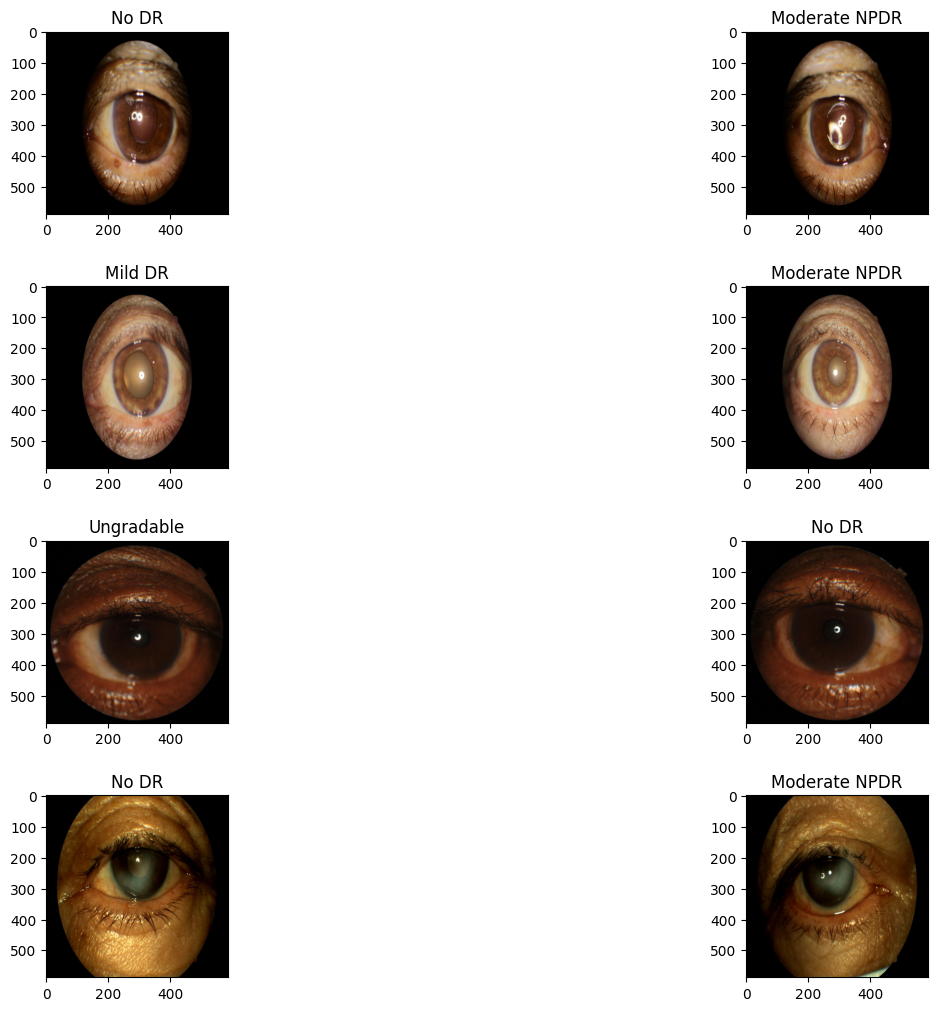

In [64]:
# Display the images from the first 10 rows of the dataframe with left/right DR discrepancies

num_rows = 5

plt.figure(figsize=(15, 15))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

eye_count = 1
for index, row in df_left_right_dr_discrepancies.iloc[0:num_rows].iterrows():
    left_eye_path, right_eye_path = split_eyes(row)

    if left_eye_path is None or right_eye_path is None:
        print("Warning: missing eye image")
        continue

    left_eye_img = cv2.imread(left_eye_path)
    right_eye_img = cv2.imread(right_eye_path)
    left_eye_img_rgb = cv2.cvtColor(left_eye_img, cv2.COLOR_BGR2RGB)
    right_eye_img_rgb = cv2.cvtColor(right_eye_img, cv2.COLOR_BGR2RGB)

    plt.subplot(num_rows, 2, eye_count)
    plt.imshow(left_eye_img_rgb)
    plt.title(row["dr_level_lft"])

    eye_count += 1

    plt.subplot(num_rows, 2, eye_count)
    plt.imshow(right_eye_img_rgb)
    plt.title(row["dr_level_rt"])

    eye_count += 1



### Identify mislabeled images visually

* Do a more comprehensive comparison on discrepancies between left vs right image labels using fiftyone
* Identify erroneous fundus images via embeddings / clustering using voxel51. There may be some fundus images that are labeled as external.  If these could be found, it would clean up the dataset.
* Make it easy to scan through images and look at labels



### Write preprocessed dataset to csv

In [ ]:
df_one_or_two_eye_images.to_csv(os.path.join(dataset_csv_root, "dataset_preprocessed.csv"))